In [228]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
#packages for data cleaning
import re
import string

In [229]:
df = pd.read_csv('./amz_tshirt_reviews.csv')

In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40521 entries, 0 to 40520
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  40521 non-null  object 
 1   attr          0 non-null      float64
 2   scores        40441 non-null  object 
 3   review_title  40441 non-null  object 
 4   reviews       40521 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.5+ MB


In [242]:
# using dictionary to convert specific columns
convert_dict = {'product_name': str,
                'attr': str,
				'review_title' : str,
                'reviews' : str
               }
df = df.astype(convert_dict)

#### when I webscrapped the data, I had a bug that caused the 'attr' column to be null, I need to re-run the webscrapping ipynb file and get the complete dataset 

In [232]:
df.shape

(40521, 5)

In [233]:
df.sample(10)

,product_name,attr,scores,review_title,reviews
22291,"Gildan Men's DryBlend Workwear T-Shirts with Pocket, 2-Pack",nan,5.0 out of 5 stars,\nNice light shirts with great price!\n,"<span class=""a-size-base review-text review-text-content"" data-hook=""review-body"">\n<span>\n Great lightweight shirt and a lot cheaper than other ones. Fit was fine and well made.\n</span>\n</span>"
10363,Russell Athletic Men's Cotton Performance Short Sleeve T-Shirt,nan,5.0 out of 5 stars,\nGreat shirt for the price!\n,"<span class=""a-size-base review-text review-text-content"" data-hook=""review-body"">\n<span>\n Even if these just last you the summer they are more than worth it. Buy these!\n</span>\n</span>"
38692,"Comfort Colors Men's Adult Short Sleeve Tee, Style 1717",nan,1.0 out of 5 stars,\nI ordered an XL and received a 4XL.\n,"<span class=""a-size-base review-text review-text-content"" data-hook=""review-body"">\n<span>\n What a joke. I could fit 3 of me in this shirt. I trashed it. Not even worth my time to return it. Buyer beware!!\n</span>\n</span>"
29002,"Gildan Men's DryBlend T-Shirt, Style G8000, 2-Pack",nan,5.0 out of 5 stars,\nGreat work shirts\n,"<span class=""a-size-base review-text review-text-content"" data-hook=""review-body"">\n<span>\n Perfect for work\n</span>\n</span>"
32230,Hanes Men's Tagless Cotton V-Neck Undershirt – Multiple Packs and Colors,nan,1.0 out of 5 stars,\nShrunk Immediately\n,"<span class=""a-size-base review-text review-text-content"" data-hook=""review-body"">\n<span>\n Medium (5'7"" 150lbs) was too big before wash, shrunk to be entirely too small after one wash. Waste of money. This is the third time purchasing - the first time the shirts I received shrunk to a normal size and lasted forever, thicker, better - they were great, second batch shrunk immediately, third, I hoped for the best, only to be disappointed. I should be able to return them.\n</span>\n</span>"
16550,Hanes Men’s Short Sleeve Graphic T-shirt Collection,nan,5.0 out of 5 stars,\nFantastic Comfort and Quality!!!\n,"<span class=""a-size-base review-text review-text-content"" data-hook=""review-body"">\n<span>\n 100% Cotton and SO Comfortable!!! Holds it shape wash after wash, I throw in regular wash and hot dryer and comes out beautiful every time, no fading and no loss of the perfect shape!!! Thick, not thin Great Quality Cotton, Super soft and cozy and looks very attractive all day long!! Love this T shirt!! Thank you!!!\n</span>\n</span>"
1865,"Gildan Men's Crew T-Shirts, Multipack",nan,3.0 out of 5 stars,\nFaded in spots. Fit well though.\n,"<span class=""a-size-base review-text review-text-content"" data-hook=""review-body"">\n<span>\n Half the shirts came with faded spots on them, Not a solid dye job at all. If I didn't already have black dye on hand then I'd be returning them. Not worth the hassle to return them when I've already have other clothing that needs dyed black. Expected a little more from Gildan. Been buying from them for years. Used to be good quality.\n</span>\n</span>"
33806,Fruit of the Loom Men's Big and Tall Tag-Free Underwear & Undershirts,nan,3.0 out of 5 stars,\nLong and thin\n,"<span class=""a-size-base review-text review-text-content"" data-hook=""review-body"">\n<span>\n These shirts are thinner, so if you don't want someone seeing your bra (if you're a female) or your nips if you're a guy lol , I'd double check in different lightings to make sure they aren't showing. They are also long. I thought they would be regular length but these are for tall people lol. The price was good though, so I'll keep these for around the house or to sleep in.\n</span>\n</span>"
1417,"Gildan Men's Crew T-Shirts, Multipack",nan,4.0 out of 5 stars,\nits a good product and good company\n,"<span class=""a-size-base review-text review-text-content"" data-hook=""review-body"">\n<span>\n I got my delivery really fast which was great and my husband says that he likes the T-shirt. It looks good on him, all I will say is if you are expe

## Extract review score as int

In [234]:
df.scores.fillna('9')
df.scores = df.scores.str.slice(start = 0, stop =1)

# How many products does this dataset have? 

In [235]:
df.product_name.nunique()

46

# What is the distribution of scores 

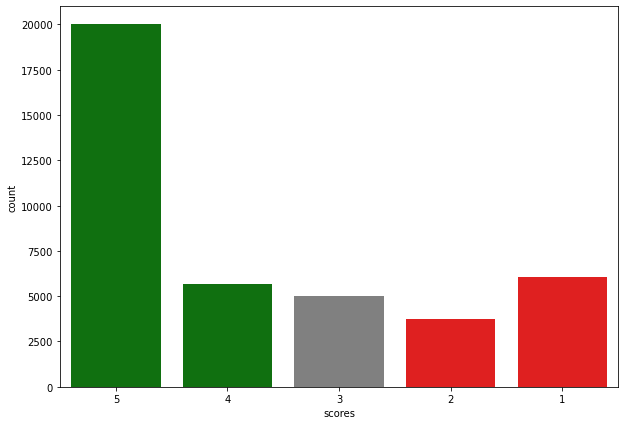

In [236]:
clrs = ['green', 'green', 'grey', 'red', 'red']
sns.countplot( data = df, x = 'scores', order = ['5', '4', '3', '2', '1'], palette=clrs)
# sb.barplot(x=idx, y=values, palette=clrs) # color=clrs)
plt.gcf().set_size_inches(10, 7)



## most of the reviews are 4 and 5 stars.
#### Since we only have few for 1 and 2 stars, I will consider 3 as a bad review. I will create a new boolean column called 'like' which answers the question: 'did the customer like the product or not?'
- 'yes': for 4 & 5 stars ratings
- 'no' :  for 3, 2, and 1 stars 

In [237]:

df.scores.isnull().sum()

80

In [238]:
df.loc[df['scores'].isnull()] = -1
df.scores = df.scores.astype(int)
def like(x):
    if x < 0:
        return None
    else:
        return x > 3

df['like'] = df.scores.apply(like)
df['like'] = df['like'].astype(bool)

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40521 entries, 0 to 40520
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  40521 non-null  object
 1   attr          40521 non-null  object
 2   scores        40521 non-null  int64 
 3   review_title  40521 non-null  object
 4   reviews       40521 non-null  object
 5   like          40521 non-null  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 1.6+ MB


In [94]:
df.like.value_counts()

True     25680
False    14841
Name: like, dtype: int64

In [170]:
#increase the column width to be able to view long reviews 
pd.set_option('max_colwidth', 500)
df['reviews'].sample(2)

17080                                          a perfect tee...except, the arm is not sewed on correctly. the lower band seam on the sleeve forever rides against the arm, an annoying tension. i can live with it but someone who lifts will be bothered. it is flexible so the binding does stretch but i don't like it. i'm 5'6", weigh 140, 38-36-34. size large fits. arm circumference where the bottom of the sleeve binds: 11".not for women like me, the flapping turkey wings. the sleeve accentuates the flutter.
30724      this is what i wanted, a light weight pocket t shirt for summer wear and sleeping.  six shirts for a little less than twenty dollars is a good deal in my book.  the only real problem is they did not come in the size i wanted so these fit a little snug and some colors seem a little heaver than other colors to me.  there were 6 in a package and i did not get to pick the package so i did get some colors i don't care for, but that is no big deal to me.  over all i got the light w

## clean 'reviews' column 

In [248]:
#replace words 
replacements = {"'ll" : " will", "'ve":" have", "'s" : " is", "'m" : " am", "'re" : " are", "'d": " would", "'t" : " not ", " ain ": "are not", " arnt " : " are not ", " dont " : " do not ",  " aint " : " are not "}

replace_shirts = {"t-shirt": "shirt", "t-shirt" : "shirt", "t shirt" : "shirt", 
                    "t-shirts" : "shirts", "t shirts" : "shirts", " s ": " small ", " l ": " large ", " m ": " medium "}
def replace_words(text):
    for x,y in replacements.items():
        text = re.sub(x, y, text)
    for x,y in replace_shirts.items():
        text = re.sub(x, y, text)

    return text


SyntaxError: invalid character '’' (U+2019) (1482159894.py, line 3)

In [243]:
def clean_reviews(text):
    # make it all lowercase 
    text = text.lower()
    # remove text between </>
    text = re.sub('\<[^>]*\>', '', text)
    # remove punctuation 
    #--- I am not going to remove punctuations for now because i might split the sentences. 
    # text = re.sub('[%s]' % re.escape(string.punctuation), '', text) 

    # remove all '\n\n'
    text = re.sub(r"\n\n ", ' ', text)
    text = text.rstrip("\n")
    
    return text
df.reviews = df.reviews.apply(clean_reviews)
df.reviews = df.reviews.apply(replace_words)

In [157]:
# !pip install nlppreprocess

In [216]:
df.sample(20)

,product_name,attr,scores,review_title,reviews,like,new_title,new_review
25231,Hanes Men's Tagless Cotton Crew Undershirt – Multiple Packs and Colors,nan,3,t shirts,"these drew up quite bad after 1 wash n dry. we dry on low so it wasnt high heat. hes 6""5. so yes they are comfortable. as shown but didnt hold their tall size once washed",False,t shirts,these drew up quite bad after wash n dry we dry low wasnt high heat hes yes they are comfortable shown but not hold their tall size once washed
6296,"Gildan Men's V-Neck T-Shirts, Multipack",nan,3,if you want quality shirts look elsewhere,"i bought these shirts because i couldn not understand paying more for a decent v-neck shirt. well now that i have owned these for a little over 6 months, the stitching is falling apart, the shirts wash and dry terribly (fade and shrink and even with my water softener) and they stretch out after a few hours of wear. i would look elsewhere before pulling the trigger on these. pay a bit more for something that will last longer. lesson learned",False,you want quality shirts look elsewhere,bought these shirts because couldn not understand paying more decent v neck shirt well now owned these little over months stitching falling apart shirts wash and dry terribly fade and shrink and even with my water softener and they stretch out after few hours wear would look elsewhere before pulling trigger these pay bit more something will last longer lesson learned
36418,Amazon Essentials Men's 2-Pack Slim-fit Short-Sleeve Crewneck T-Shirt,nan,3,its alright,"it is a shirt. a cheap comfy shirt, it shrunk tho so be careful on how you laundry it.",False,its alright,shirt cheap comfy shirt shrunk tho careful how you laundry it
18380,Amazon Essentials Women's 2-Pack V-Neck Classic-fit Short-Sleeve Tee Shirt,nan,5,comfortable shirts,"i really like these shirts. they are perfect, not too sheer and not too heavy. they’re soft to the touch and have kept that feeling through a few washes. fit as expected. for a looser fit size up.",True,comfortable shirts,really like these shirts they are perfect not too sheer and not too heavy they re soft touch and kept feeling through few washes fit expected looser fit size up
37930,Dickies Men's Heavyweight Crew Neck Short Sleeve Tee Big-Tall,nan,5,dickies mens heavyweight crew neck short sleeve tee,"the material much more thick than other shirts, which is what i wanted. and, they are 100% cotton. there wasn not any noticeable shrinking after the first wash, but i do use cold water and an automatic dry setting in the machines. i will definitely buy more.",True,dickies mens heavyweight crew neck short sleeve tee,material much more thick than shirts which what wanted and they are cotton there wasn not noticeable shrinking after first wash but use cold water and automatic dry setting in machines will definitely buy more
23797,"Champion Men's Classic T-Shirt, Screen Print Script",nan,2,great look subpar fit,"great looking shirt, doesn not fit well though... it is tight at the stomach and loose at the chest. fit more like a women is shirt. gave it to the wife.",False,great look subpar fit,great looking shirt doesn not fit well though tight stomach and loose chest fit more like women shirt gave wife
9708,Champion Men's Classic Jersey Tee,nan,4,nice value tee shirt,nice basic tee shirt with nice quality and a nice price.,True,nice value tee shirt,nice basic tee shirt with nice quality and nice price
31611,"Hanes Men's ComfortSoft Tagless Pocket T's, 6 Pack",nan,2,poor quality,they were thin and shrunk after a wash,False,poor quality,they thin and shrunk after wash
8767,Under Armour Men's Tech 2.0 Short-Sleeve T-Shirt,nan,5,quality t’s,i like ua non cotton shirts. when you perspire it doesn’t weigh down the garment. ua has long been associated with quality. i’ve bought cheaper non name brand similar shirts and they are not the same. i try ua when they are on sale. winner winner!... chicken dinner!,True,quality t s,like ua non cotton shirts wh

## clean 'review_title'

In [246]:
def clean_titles(title):

    title = str(title)
    #make all lowercase 
    title = title.lower()
    #remove punctuation
    title = re.sub('[%s]' % re.escape(string.punctuation), '', title) 

    # remove all '\n'
    title = re.sub(r"\n", '', title)
    return title




df.review_title = df.review_title.apply(clean_titles) 
df.review_title = df.review_title.apply(replace_words)

In [247]:
df.sample(5)

,product_name,attr,scores,review_title,reviews,like
24785,Hanes Women's X-Temp V-Neck T-Shirt,nan,2,it’s just ok,they run small and when you wash them they shrink .the fabric is rough and i know it was not overly expensive but the amazon tech shirts are way better,False
13355,"Gildan Men's Softstyle Cotton T-Shirt, Style G64000, 2-Pack",nan,5,great valuefit was true to size,fit was great..overall a great value.,True
1355,"Gildan Men's Crew T-Shirts, Multipack",nan,4,size discrepancy,"get one size up from the usual.i may have grown outward slightly since last purchasing additions to the classy tshirt wardrobe collection or lack thereof but these shirts seem smaller than the usual size l.xl are reserved for larger people, extra large people according to the label, in which i’m welcoming myself to that illustrious club due to these south east asian style mini tshirts.otherwise quality is good, they would be comfortable shirts if not for the slight breeze on my bellybutton...",True
30231,Hanes Men's Short Sleeve Beefy-T (Pack of 2),nan,5,good quality great value,"i wouldn not recommend these for a summer shirt, as they are thicker cotton. i ordered the xl thinking it would allow me to conceal carry better. unfortunately, i think i have grown more than i thought(in the belly) and should have got the double x tall instead of the xl tall. they fit nice, i just needed something baggier. the length was perfect, the shirt goes down to mid front pocket maybe even touches the bottom of the pocket. it doesn not feel tight at all, and it is more of a slend...",True
27556,Hanes Ultimate Men's 5-Pack Tagless ComfortSoft Crewneck T-Shirt,nan,1,very disappointing hanestee,"i am very disappointed in this purchase. these tees sag and hang, looking terrible and cheap. the neck has stretched during the first wear, to the point that it doesn not show within my open collar shirt. i don not feel very confident these are hanes quality and they were over $21.00 for six! i will shop target or costco now for tees! (it will be interesting how my refund is handled, whether i will be charged returned shipping costs: i am getting a message the cost will be deducted from ...",False


## split the reviews columns

In [11]:
df['reviews_splitted'] = df.reviews.apply(lambda x: re.split('[,.]', str(x)))

In [ ]:
df.reviews_splitted

In [13]:
df['review_length'] = df.reviews_splitted.apply(lambda x: len(x))

## CountVectorize

In [15]:
!conda install scikit-learn=1.0

Solving environment: \ ^C
failed with initial frozen solve. Retrying with flexible solve.

CondaError: KeyboardInterrupt



In [14]:
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(df.review_title)
data_dtm = pd.DataFrame(data_cv.toarray()
                        , columns = cv.get_feature_names_out())
data_dtm.index = data.index
data_dtm

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names_out'

In [193]:
df.review_length

0        1
1        1
2        1
3        1
4        1
        ..
40516    1
40517    1
40518    1
40519    1
40520    1
Name: review_length, Length: 40521, dtype: int64

# NLTK

In [225]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

all_stopwords = stopwords.words('english')

#there are important words in reviews that I don't want to remove, such as "size up" and "size down"
do_not_remove = ['not', 'no', 'up', 'down', 'above', 'below', 'off', 'again', 'too', 'y']
for word in all_stopwords:
    if (word in do_not_remove):
        all_stopwords.remove(word)

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [226]:
len(all_stopwords)

171

In [214]:
all_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'below',
 'to',
 'from',
 'down',
 'in',
 'out',
 'on',
 'over',
 'under',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'othe

In [222]:
df.reviews.head(10)

0      i recommend these shirts. i am 5'8" and 140", i do not like tighshirts so i bought a large. i am happy with it, although i am sure that a medium would have worked.i will compare the gilden shirt with the fruit of the loom platinum that you will see at wal-mart.pro - the gilden appears to be better built and the sizing was consistent on the two shirts that came in the package. the neck was smaller, without being tight. i am guessing that fabric around the neck will not wrinkle up, unlike ma...
1      my husband actually has shirts older than our college-age grandson.  some looked as if he was present and agare notst the wall at the valentine is day massacre.  i have slowly been trashing them as he brings them to be laundered and i was looking to replace some of his around-the house shirts.  he likes them reasonably soft and medium weight.  i sent off for a set of two of these and he really likes them.  he wore them one right after the other, and the second they had went thru wash

In [220]:
#remove stopwords from the review_titles 
corpus=[]


for title in df['new_review']:
    title = title.split()
    title = [ps.stem(word) for word in title if not word in set(all_stopwords)]
    title = ' '.join(title)
    corpus.append(title)




In [221]:
corpus

['recommend shirt not like tighshirt bought larg happi although sure medium would work compar gilden shirt fruit loom platinum see wal mart pro gilden appear better built size consist two shirt came packag neck smaller without tight guess fabric around neck not wrinkl up unlik mani fruit loom no loos thread unlik mani fruit loom gilden heavier fabric better year live east tennesse not want see shirt also no one see would want wear see shirt con fruit loom much softer first wash wash gildan shirt warm water two minut dryer energi save gilden tag not good fruit loom no tag cut tag without problem gilden fine gilden slightli expens brand inexpens neutral neither brand bleed color wash gilden one time not know whether fade fruit loom shirt fade take mani wash occur hope review help updat june gildan shirt bought previous held up reason well money not shrink not fade howev not get softer wash warm dri three minut energi saver purchas gildan replac one wore not wash yet bought galapago blue 

160